In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
import xarray as xr
import scipy.stats as stats
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
sns.set_theme(palette="colorblind")

In [3]:
# adding 2 integers in Python
a = 2
b = 3
c = a + b
print(c)

5


In [4]:
# adding 2 random variables in PyMC
with pm.Model() as example:
    a = pm.Normal("a", 2, 0.5)
    b = pm.Normal("b", 3, 0.2)
    c = pm.Deterministic("c", a + b)
    trace_1 = pm.sample()

Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [a, b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


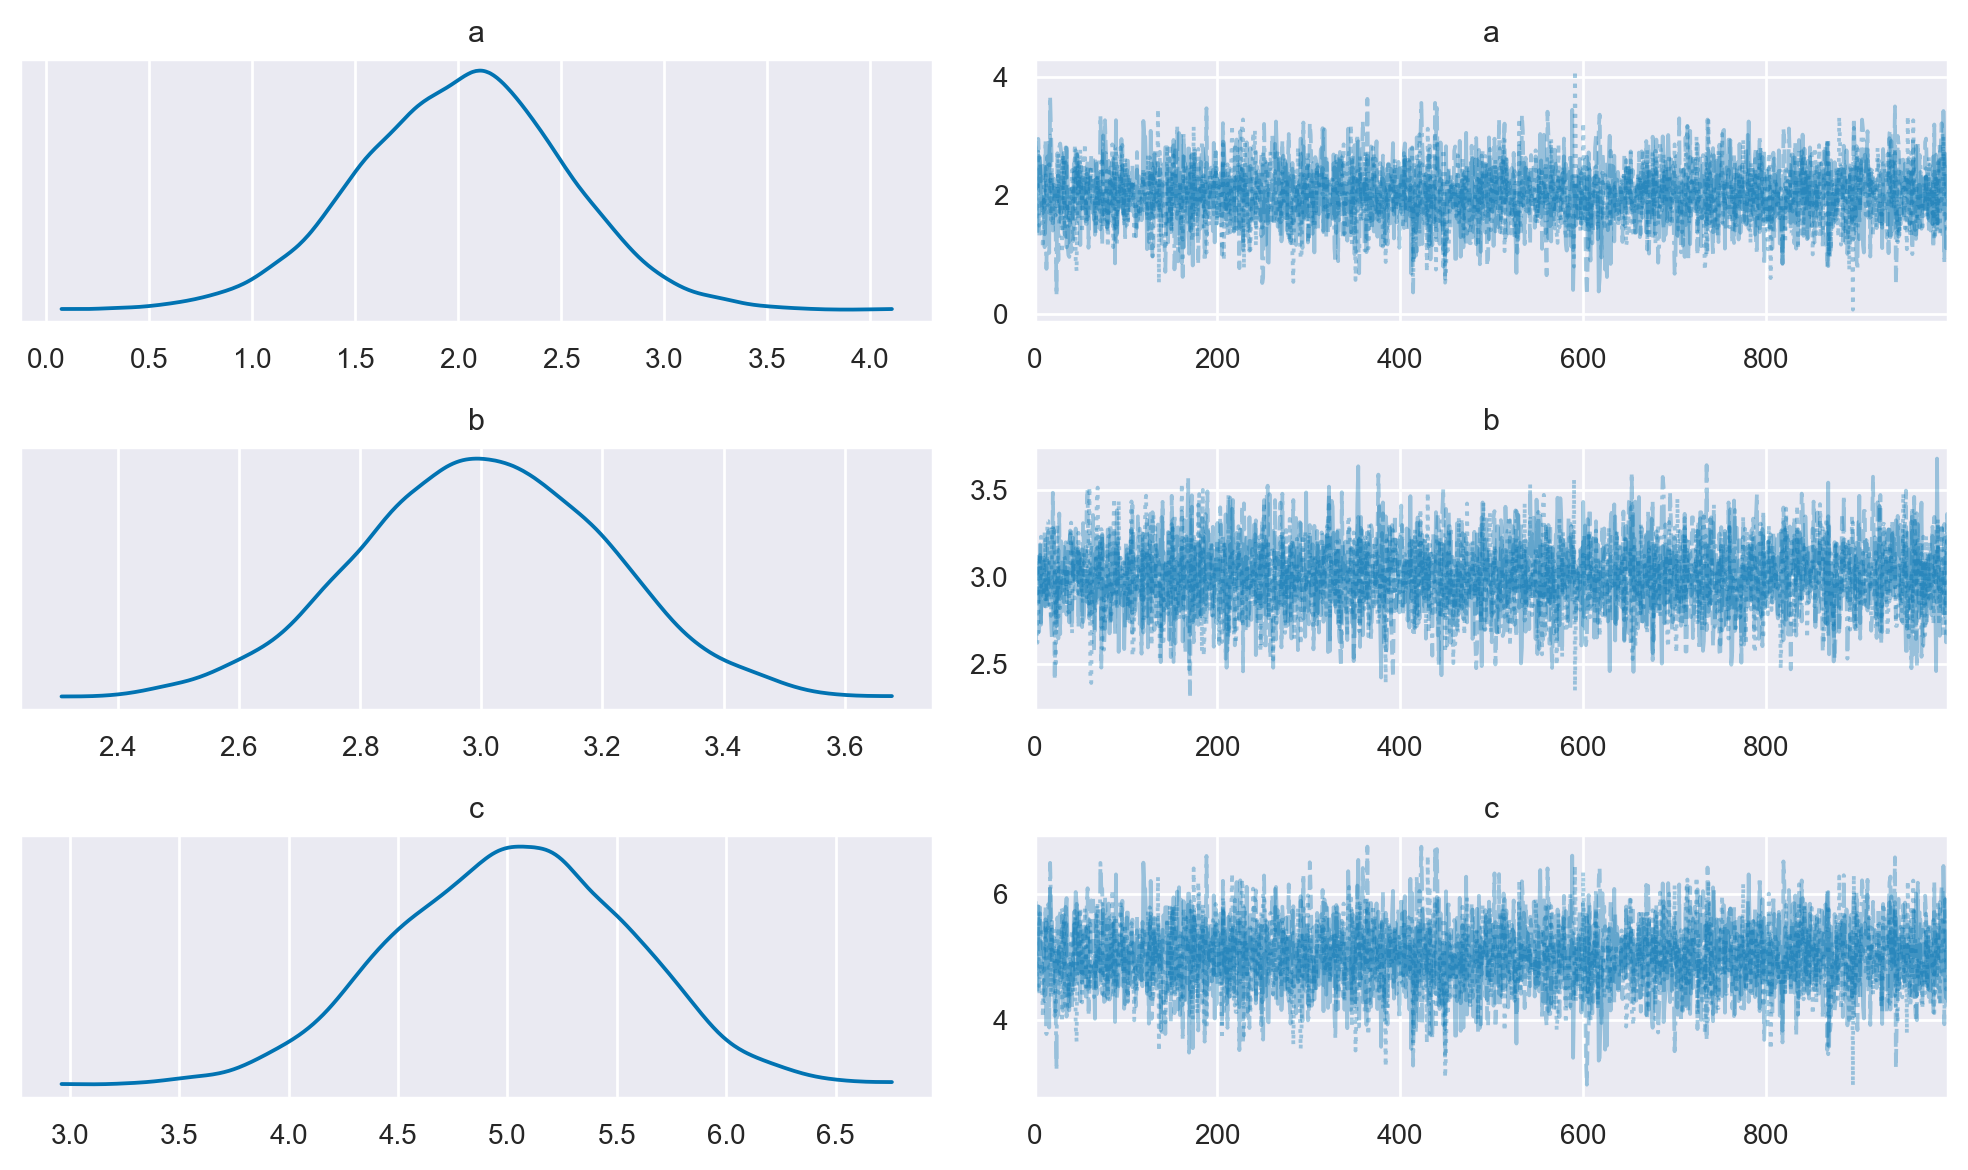

In [5]:
az.plot_trace(trace_1, figsize=(10, 6), combined=True)
plt.tight_layout()

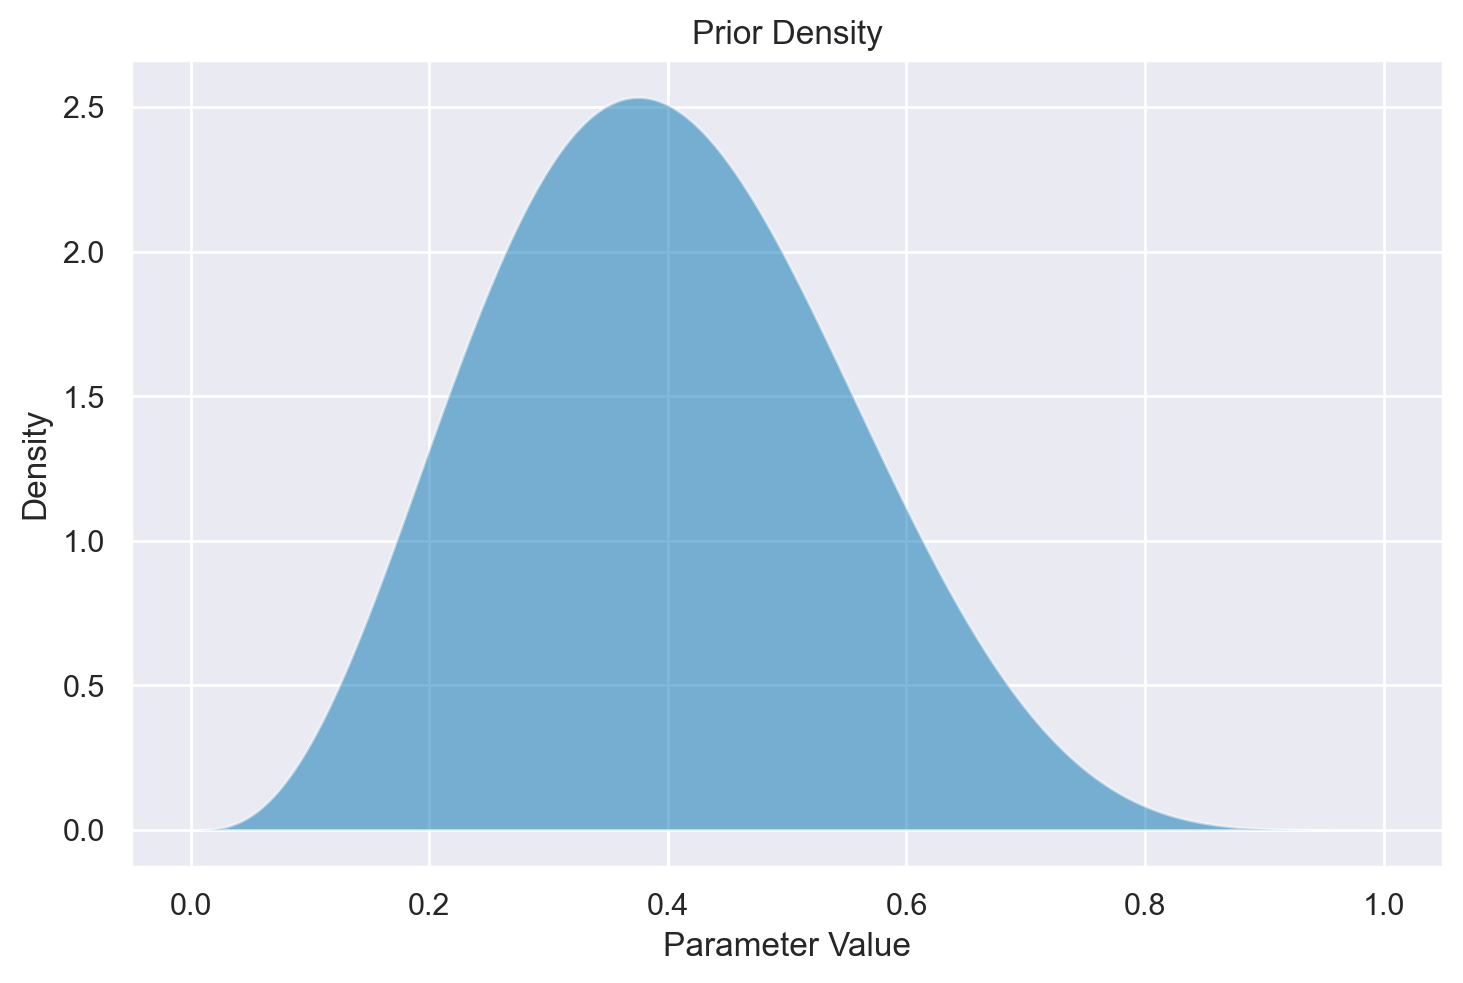

In [6]:
x = np.linspace(0, 1, 1000)

prior_density = stats.beta.pdf(x, 4, 6)

plt.fill_between(x, prior_density, alpha=0.5)
plt.xlabel("Parameter Value")
plt.ylabel("Density")
plt.title("Prior Density");

In [7]:
y = 14
ntrials = 100

In [8]:
alpha_prior = 4
beta_prior = 6

In [9]:
with pm.Model() as bb_model:
    # Prior
    theta = pm.Beta("theta", alpha=alpha_prior, beta=beta_prior)
    # Likelihood
    obs = pm.Binomial("obs", p=theta, n=ntrials, observed=y)

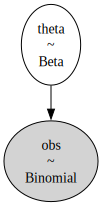

In [10]:
pm.model_to_graphviz(bb_model)

In [11]:
with pm.Model() as bb_model:
    y_data = pm.ConstantData("y_data", y)
    n_trials = pm.ConstantData("n_trials", ntrials)
    theta = pm.Beta("theta", alpha=alpha_prior, beta=beta_prior)
    obs = pm.Binomial("obs", p=theta, n=n_trials, observed=y_data)

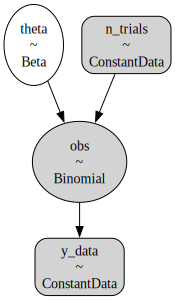

In [12]:
pm.model_to_graphviz(bb_model)

In [13]:
with bb_model:
    fit = pm.find_MAP()

In [14]:
fit["theta"]

array(0.15740746)

In [15]:
with bb_model:
    idata = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


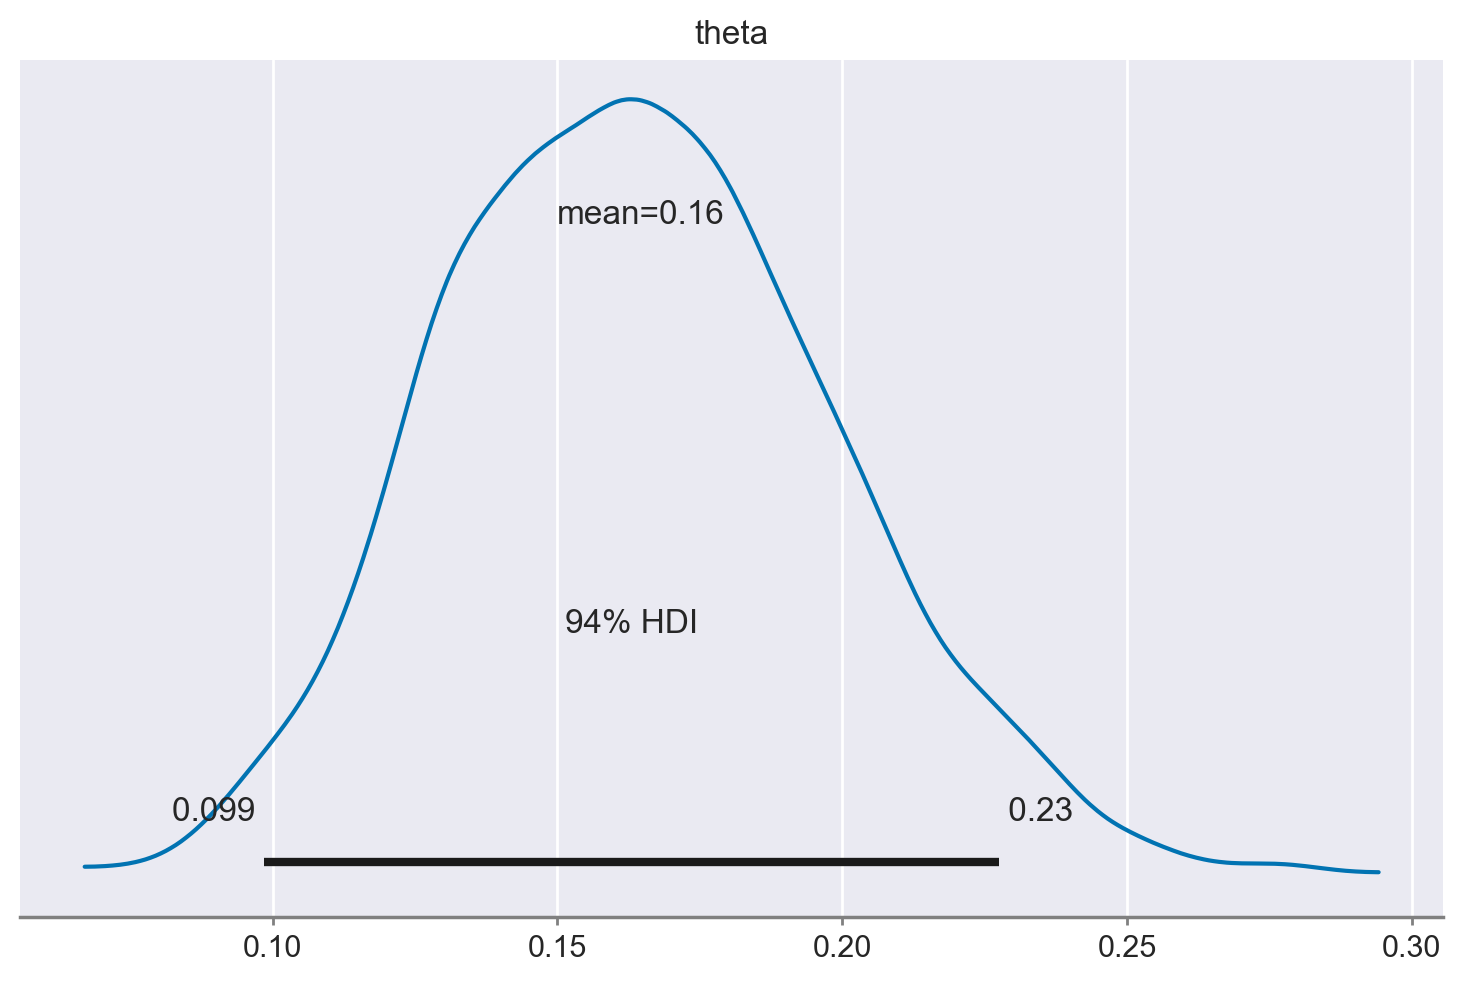

In [16]:
az.plot_posterior(idata);

In [17]:
with bb_model:
    metropolis_idata = pm.sample(step=pm.Metropolis())

Multiprocess sampling (4 chains in 4 jobs)


Metropolis: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


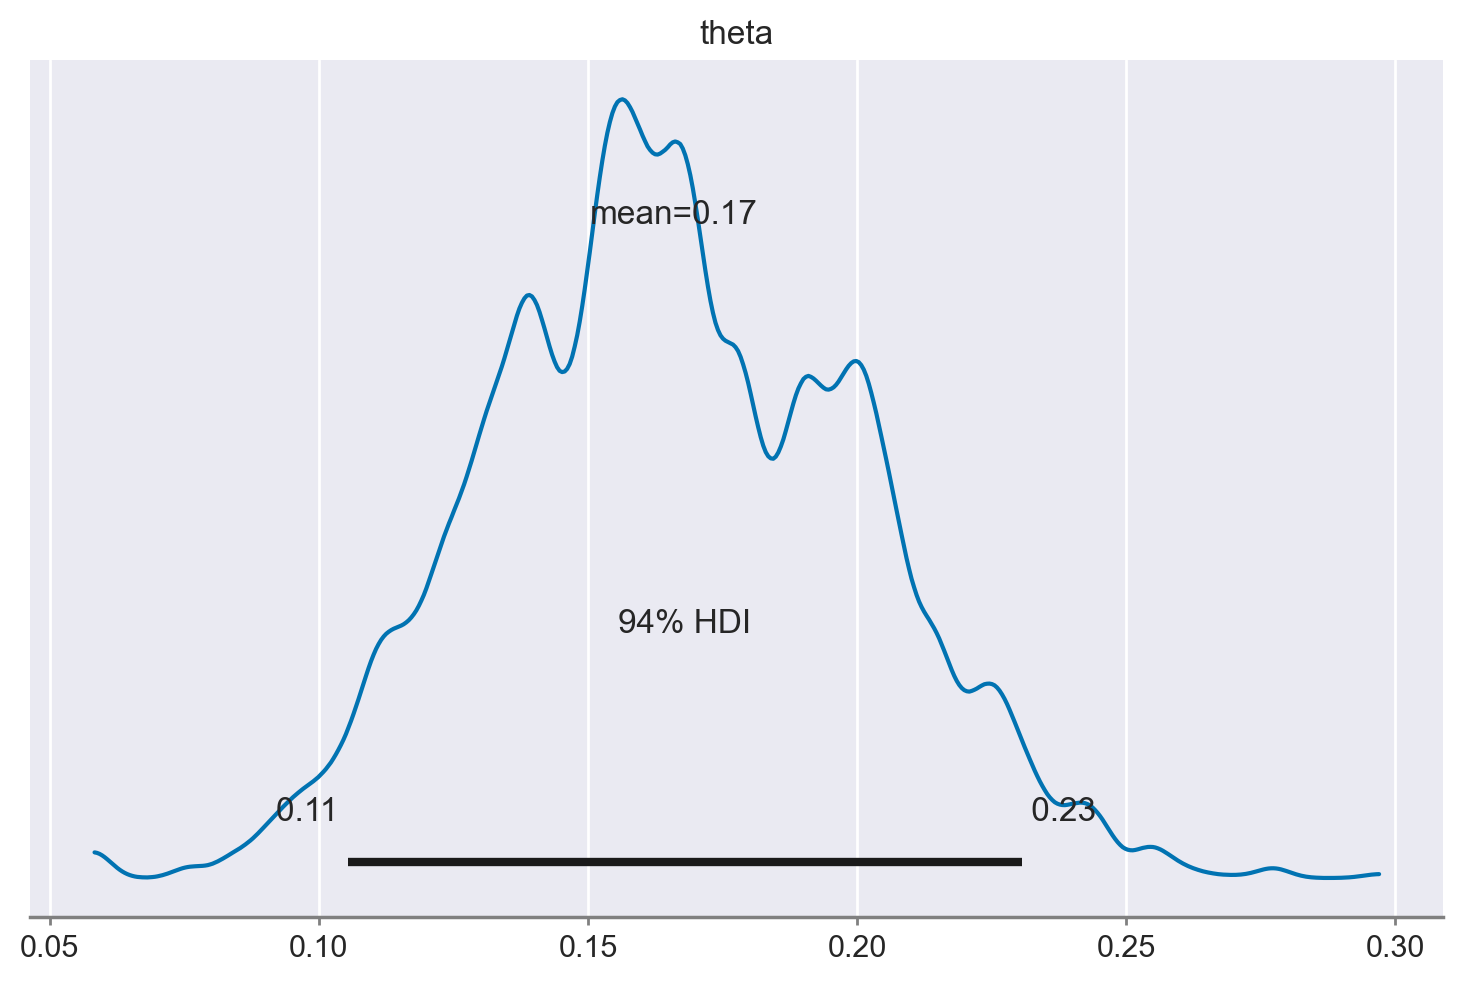

In [18]:
_ = az.plot_posterior(metropolis_idata)

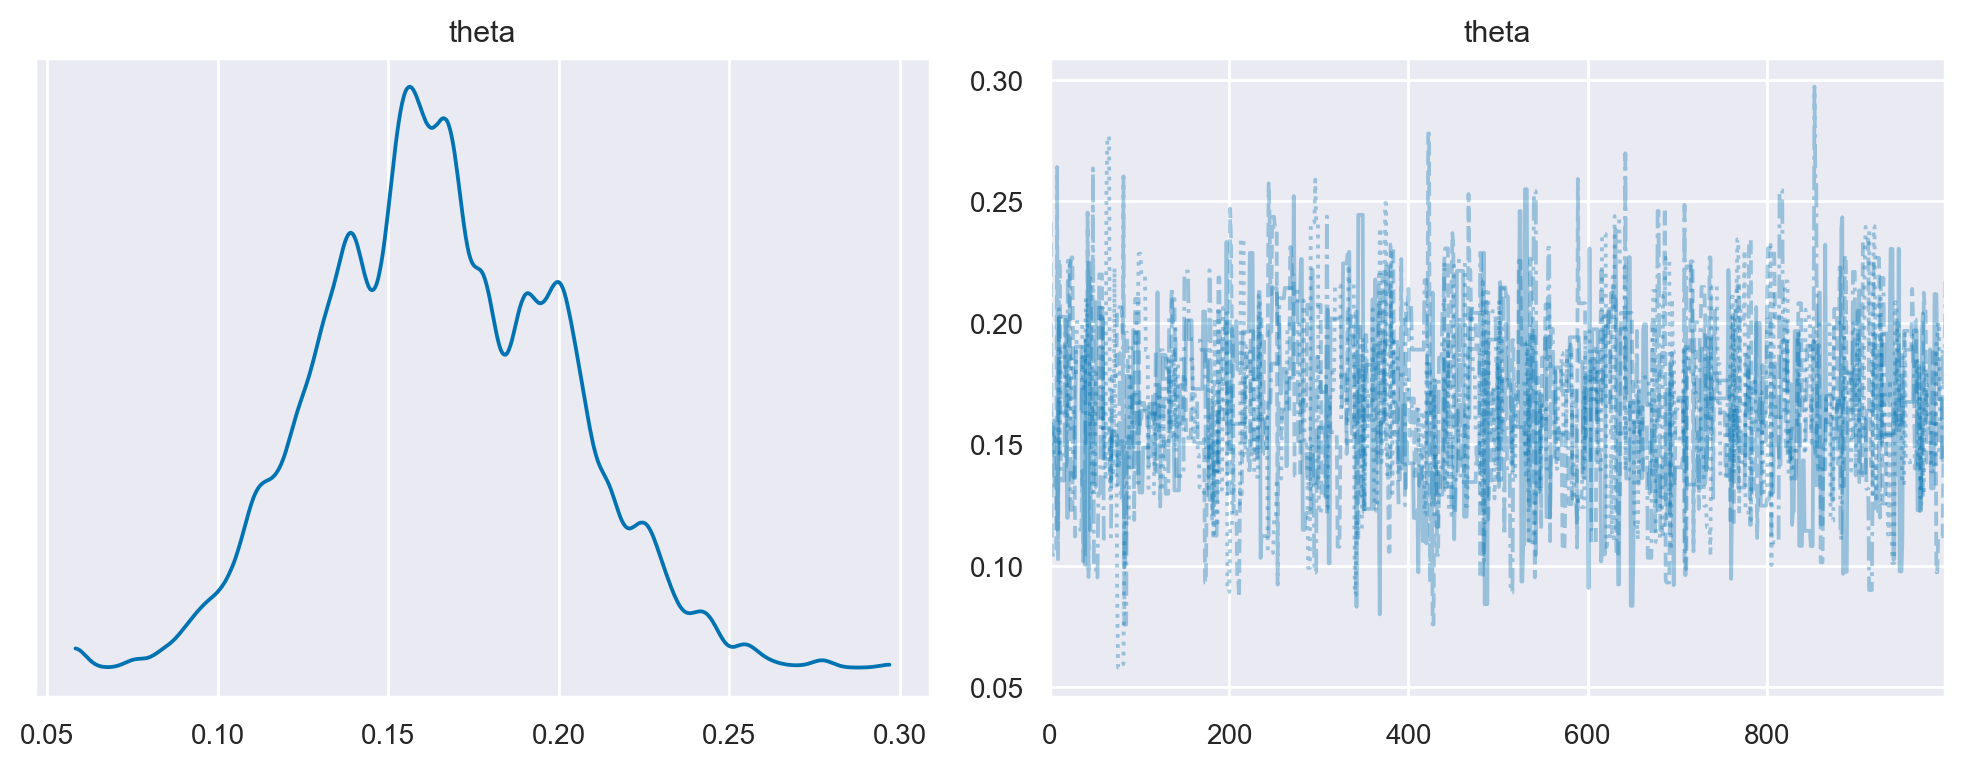

In [19]:
az.plot_trace(metropolis_idata, combined=True, figsize=(10, 4))
plt.tight_layout()
plt.show()

In [20]:
post = az.extract(metropolis_idata)
post

<xarray.Dataset>
Dimensions:  (sample: 4000)
Coordinates:
  * sample   (sample) object MultiIndex
  * chain    (sample) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
Data variables:
    theta    (sample) float64 0.1587 0.1587 0.1587 ... 0.1729 0.1729 0.2174
Attributes:
    created_at:                 2024-01-23T07:44:28.724514
    arviz_version:              0.17.0
    inference_library:          pymc
    inference_library_version:  5.10.3
    sampling_time:              27.104933977127075
    tuning_steps:               1000

In [21]:
post["theta"].shape

(4000,)

Text(0, 0.5, 'Densità')

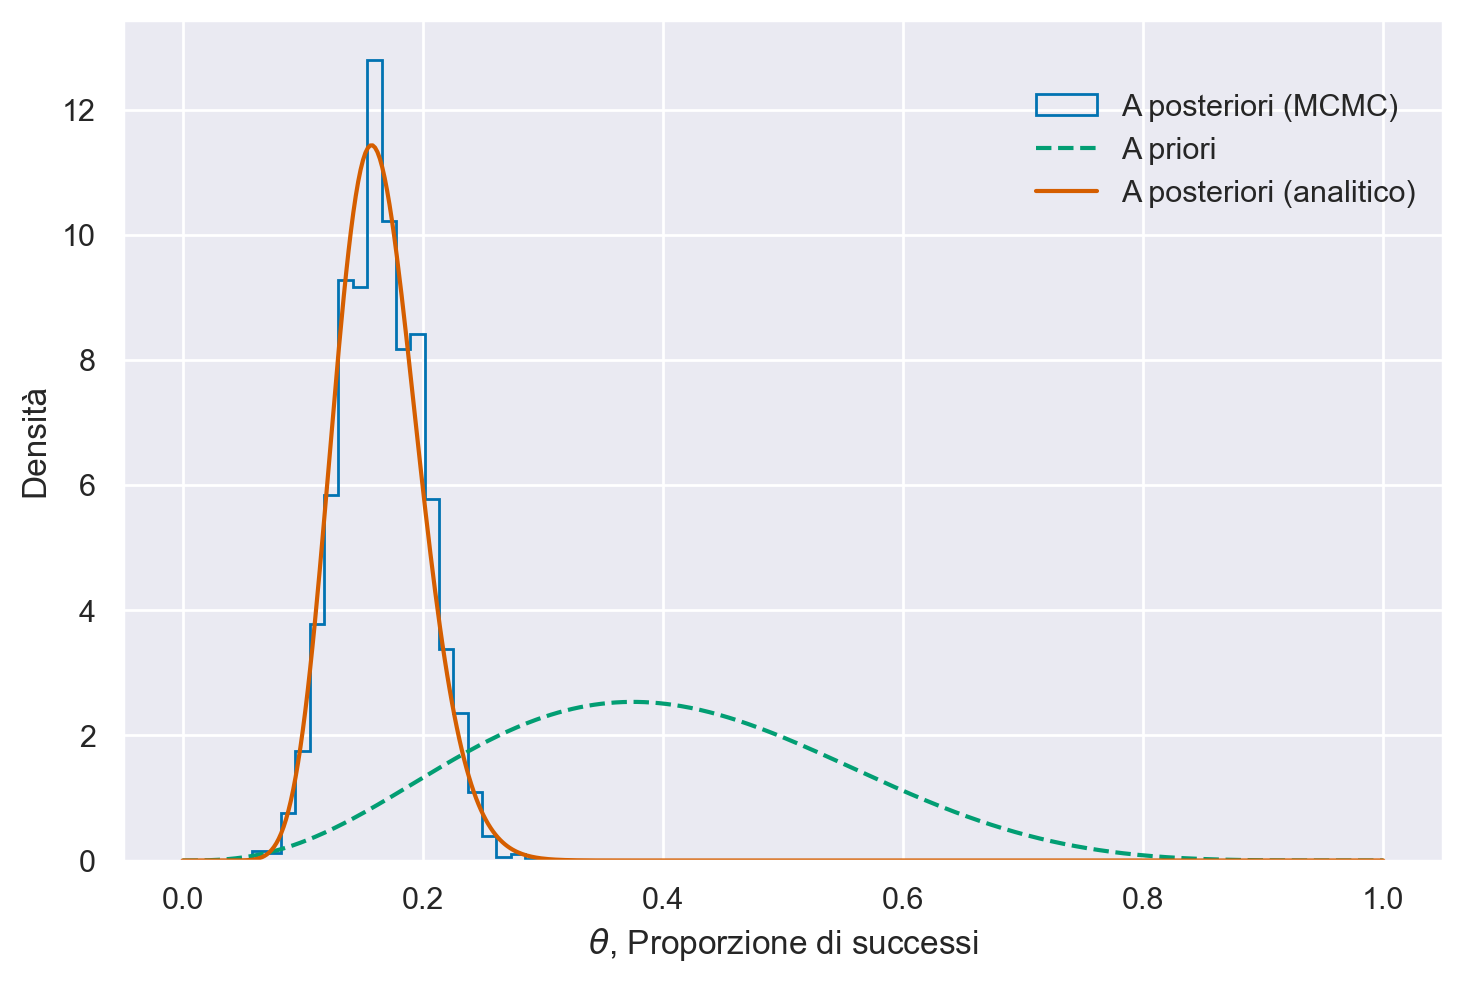

In [22]:
p_post = post["theta"]

# Posterior: Beta(alpha + y, beta + n - y)
alpha_post = alpha_prior + y
beta_post = beta_prior + ntrials - y

plt.hist(
    p_post,
    bins=20,
    histtype="step",
    density=True,
    label="A posteriori (MCMC)",
    color="C0",
)

# Plot the analytic prior and posterior beta distributions
x = np.linspace(0, 1, 500)
plt.plot(
    x, stats.beta.pdf(x, alpha_prior, beta_prior), "--", label="A priori", color="C2"
)
plt.plot(
    x,
    stats.beta.pdf(x, alpha_post, beta_post),
    label="A posteriori (analitico)",
    color="C3",
)

# Update the graph labels
plt.legend(title=" ", loc="best")
plt.xlabel("$\\theta$, Proporzione di successi")
plt.ylabel("Densità")

In [23]:
metropolis_idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

In [24]:
post = metropolis_idata.posterior
post

<xarray.Dataset>
Dimensions:  (chain: 4, draw: 1000)
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
Data variables:
    theta    (chain, draw) float64 0.1587 0.1587 0.1587 ... 0.1729 0.1729 0.2174
Attributes:
    created_at:                 2024-01-23T07:44:28.724514
    arviz_version:              0.17.0
    inference_library:          pymc
    inference_library_version:  5.10.3
    sampling_time:              27.104933977127075
    tuning_steps:               1000

In [25]:
post["theta"]

<xarray.DataArray 'theta' (chain: 4, draw: 1000)>
array([[0.15869112, 0.15869112, 0.15869112, ..., 0.14327647, 0.14327647,
        0.14327647],
       [0.16299578, 0.16299578, 0.14843351, ..., 0.15872539, 0.15872539,
        0.15872539],
       [0.2409699 , 0.2409699 , 0.1045378 , ..., 0.14408287, 0.14408287,
        0.15087252],
       [0.15678982, 0.15678982, 0.15678982, ..., 0.17292851, 0.17292851,
        0.21738697]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999

In [26]:
post["theta"].shape

(4, 1000)

In [27]:
post["theta"].data

array([[0.15869112, 0.15869112, 0.15869112, ..., 0.14327647, 0.14327647,
        0.14327647],
       [0.16299578, 0.16299578, 0.14843351, ..., 0.15872539, 0.15872539,
        0.15872539],
       [0.2409699 , 0.2409699 , 0.1045378 , ..., 0.14408287, 0.14408287,
        0.15087252],
       [0.15678982, 0.15678982, 0.15678982, ..., 0.17292851, 0.17292851,
        0.21738697]])

In [28]:
post["theta"].dims

('chain', 'draw')

In [29]:
post["theta"].coords

Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999

In [30]:
# Trasformazione in un array unidimensionale
theta_1d = post["theta"].data.reshape(-1)
theta_1d

array([0.15869112, 0.15869112, 0.15869112, ..., 0.17292851, 0.17292851,
       0.21738697])

In [31]:
np.mean(theta_1d)

0.16583346628246737

In [32]:
np.mean(post["theta"].data)

0.16583346628246737

In [33]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Tue Jan 23 2024

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.19.0

xarray    : 2023.12.0
pymc      : 5.10.3
scipy     : 1.11.4
matplotlib: 3.8.2
seaborn   : 0.13.0
numpy     : 1.26.2
arviz     : 0.17.0

Watermark: 2.4.3

